In [3]:
import os
import pandas as pd
import numpy as np
from scipy.stats import gmean
import matplotlib.pyplot as plt

# Set the working directory
path = os.getcwd()
os.chdir(path+"//..")

# Load O*NET task data
task_data = pd.read_csv("Data/onet_tasks.csv")

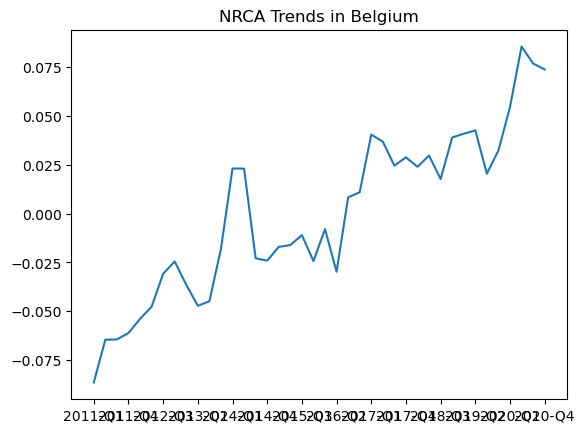

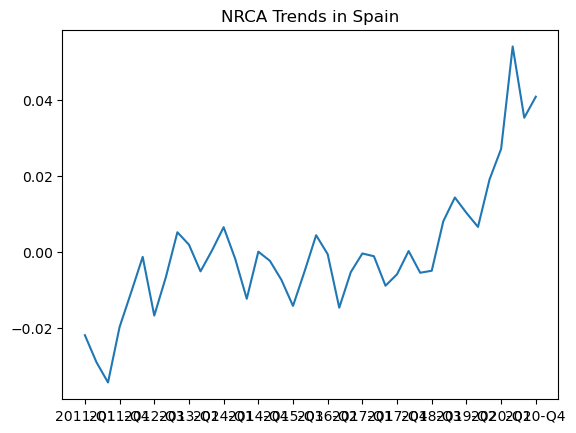

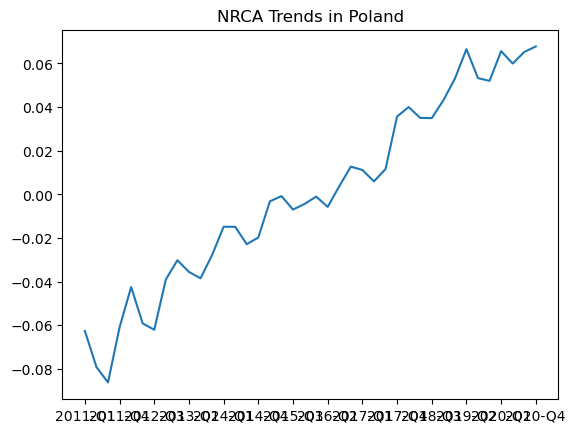

In [6]:
# Load Eurostat employment data
employment_data = {}
for sheet in range(1, 10):  # ISCO categories 1 to 9
    employment_data[f"isco{sheet}"] = pd.read_excel("Data/Eurostat_employment_isco.xlsx", sheet_name=f"ISCO{sheet}")

# Function to calculate total workers by country
def calculate_country_totals(data_dict, countries):
    totals = {country: 0 for country in countries}
    for df in data_dict.values():
        for country in countries:
            totals[country] += df[country]
    return totals

# List of countries to analyze
countries = ["Belgium", "Spain", "Poland"]

# Calculate total workers for each country
country_totals = calculate_country_totals(employment_data, countries)

# Add ISCO occupation category column to each DataFrame
for i, df in employment_data.items():
    df['ISCO'] = int(i[-1])

# Combine all ISCO data into one DataFrame
all_data = pd.concat(employment_data.values(), ignore_index=True)

# Add total worker counts for each country to the combined DataFrame
for country in countries:
    all_data[f"total_{country}"] = pd.concat([country_totals[country]] * 9, ignore_index=True)
    all_data[f"share_{country}"] = all_data[country] / all_data[f"total_{country}"]

# Process task data: Extract first digit of ISCO code
task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# Aggregate task data by 1-digit ISCO code
aggdata = task_data.groupby(["isco08_1dig"]).mean().drop(columns=["isco08"])

# Merge task and employment data
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')

# Function to standardize task values
def standardize_task_values(df, task_cols, weight_col_prefix):
    standardized_cols = {}
    for task in task_cols:
        for country in countries:
            weights = df[f"share_{country}"]
            temp_mean = np.average(df[task], weights=weights)
            temp_sd = np.sqrt(np.average((df[task] - temp_mean)**2, weights=weights))
            standardized_cols[f"std_{country}_{task}"] = (df[task] - temp_mean) / temp_sd
    return pd.DataFrame(standardized_cols)

# Define non-routine cognitive analytical tasks
nrca_tasks = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]

# Standardize task values
standardized_tasks = standardize_task_values(combined, nrca_tasks, "share")
combined = pd.concat([combined, standardized_tasks], axis=1)

# Calculate NRCA intensity for each country
for country in countries:
    combined[f"{country}_NRCA"] = sum(combined[f"std_{country}_{task}"] for task in nrca_tasks)

# Standardize NRCA values
for country in countries:
    weights = combined[f"share_{country}"]
    temp_mean = np.average(combined[f"{country}_NRCA"], weights=weights)
    temp_sd = np.sqrt(np.average((combined[f"{country}_NRCA"] - temp_mean)**2, weights=weights))
    combined[f"std_{country}_NRCA"] = (combined[f"{country}_NRCA"] - temp_mean) / temp_sd

# Aggregate NRCA values over time for each country
agg_nrca = {}
for country in countries:
    combined[f"multip_{country}_NRCA"] = combined[f"std_{country}_NRCA"] * combined[f"share_{country}"]
    agg_nrca[country] = combined.groupby("TIME")[f"multip_{country}_NRCA"].sum().reset_index()

# Plot NRCA trends for each country
for country, data in agg_nrca.items():
    plt.plot(data["TIME"], data[f"multip_{country}_NRCA"])
    plt.xticks(range(0, len(data), 3), data["TIME"][::3])
    plt.title(f"NRCA Trends in {country}")
    plt.show()
